## 1. Setup

In [1]:
import ray
import cv2
import shutil
import dsutils
import tifffile
import numpy as np
from PIL import Image
from glob import glob
from tqdm import tqdm

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-03-13 04:44:01,862	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
ray.init()

2024-03-13 04:44:05,052	INFO worker.py:1724 -- Started a local Ray instance.


Python version:,3.10.13
Ray version:,2.9.2


## 2. Config

In [4]:
scales = [0.5, 1.0, 1.5]
crop_size = 512
valid_threshold = 0.5
data_name = 'orsi-sod'

In [5]:
root_dir = '/hdd1/ysyoon/datasets'
base_dir = f'{root_dir}/{data_name}/base'
post_dir = f'{root_dir}/{data_name}/post'

In [6]:
dsutils.io.reset_directory(post_dir)
metainfo = dsutils.io.read_json(f'{base_dir}/metainfo.json')
metainfo['post'] = {
    'scales': scales,
    'crop_size': crop_size,
    'valid_threshold': valid_threshold
}
dsutils.io.write_json(metainfo, f'{post_dir}/metainfo.json')

In [7]:
metainfo

{'name': 'orsi-sod',
 'task': 'semantic-segmentation',
 'description': 'Salient Object Detection via Multiscale Joint Region and Boundary Model',
 'url': 'https://github.com/wchao1213/ORSI-SOD',
 'classes': ['background', 'saliency'],
 'post': {'scales': [0.5, 1.0, 1.5], 'crop_size': 512, 'valid_threshold': 0.5}}

## Process

In [8]:
def rescale_and_crop(image, label, scale, crop_size, valid_threshold):
    min_size = crop_size * valid_threshold
    
    width = int(image.width * scale)
    height = int(image.height * scale)
    
    image = image.resize((width, height), Image.BICUBIC)
    label = label.resize((width, height), Image.NEAREST)

    for left in range(0, width, crop_size):
        for top in range(0, height, crop_size):
            right = min(left+crop_size, width)
            bottom = min(top+crop_size, height)
            bbox = (left, top, right, bottom)
            
            crop_image = image.crop(bbox)
            crop_label = label.crop(bbox)

            crop_width, crop_height = crop_image.size
            if crop_width < min_size or crop_height < min_size:
                continue
            
            elif crop_width < crop_size or crop_height < crop_size:
                crop_image = crop_image.resize((crop_size, crop_size), Image.BICUBIC)
                crop_label = crop_label.resize((crop_size, crop_size), Image.NEAREST)
            
            yield crop_image, crop_label, bbox


@ray.remote
def process(image_path, scales, crop_size, valid_threshold, images_dir, labels_dir):
    label_path = image_path.replace('/images/', '/labels/')  
    file_name = dsutils.io.get_file_name(image_path)
    
    image = Image.open(image_path)
    label = Image.open(label_path)
    
    for scale in scales:
        scale_name = 'scale-' + str(scale).replace('.', '-')
        for crop_image, crop_label, bbox in rescale_and_crop(image, label, scale, crop_size, valid_threshold):
            bbox_name = 'bbox-' + str(bbox[0]) + '-' + str(bbox[1])
            crop_name = f'{file_name}_{scale_name}_{bbox_name}'
            crop_image.save(f'{images_dir}/{crop_name}.png')
            crop_label.save(f'{labels_dir}/{crop_name}.png')

In [9]:
for split in ['train', 'valid']:
    images_dir = f'{post_dir}/{split}/images'
    labels_dir = f'{post_dir}/{split}/labels'
    dsutils.io.reset_directory(images_dir)
    dsutils.io.reset_directory(labels_dir)

    image_paths = glob(f'{base_dir}/{split}/images/*.png')
    objs = [process.remote(image_path, scales, crop_size, valid_threshold, images_dir, labels_dir) for image_path in image_paths]
    for obj in tqdm(objs):
        ray.get(obj)

100%|██████████| 1718/1718 [00:03<00:00, 485.07it/s]


In [10]:
ray.shutdown()

## 4. Debug

In [11]:
palette = dsutils.image.sample_palette()

In [12]:
image_paths = glob(f'{post_dir}/*/images/*.png')

In [85]:
image_path = image_paths[np.random.randint(len(image_paths))]
label_path = image_path.replace('/images/', '/labels/')

In [86]:
image = Image.open(image_path)
label = Image.open(label_path)
label = dsutils.segmentation.visualize_label(label, palette)

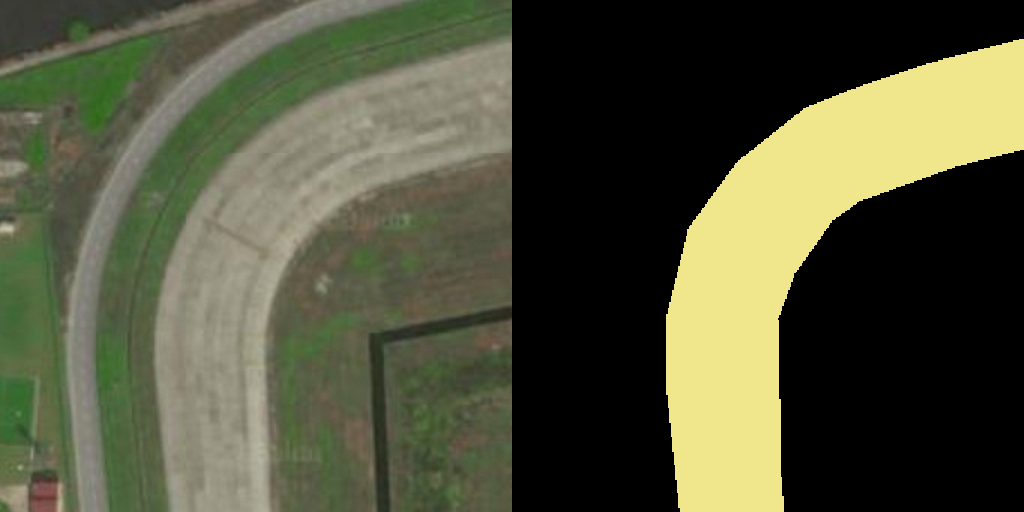

In [87]:
dsutils.image.concat_images_horizontal([image, label])